# WGAN

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b7e876180d93986d77bd479943ce4d7841db6f79101da6290220c8855ae9fe41
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from medmnist import ChestMNIST
from torch.utils.tensorboard import SummaryWriter
from scipy.linalg import sqrtm
import torch.nn.functional as F
from torchvision.models import inception_v3


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ChestMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 82.8M/82.8M [00:01<00:00, 56.9MB/s]


In [7]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

# Define Critic (Discriminator) for WGAN
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [8]:

# Hyperparameters
latent_dim = 100
lr = 0.00005
epochs = 50
critic_iterations = 5
weight_clip = 0.01

In [9]:
# Initialize models
generator = Generator(latent_dim).to(device)
critic = Critic().to(device)

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

In [10]:
# TensorBoard setup
writer = SummaryWriter("runs/WGAN_training")

In [11]:
# Training Loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Train Critic multiple times per Generator step
        for _ in range(critic_iterations):
            optimizer_C.zero_grad()
            
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z).detach()
            
            c_loss = -torch.mean(critic(real_images)) + torch.mean(critic(fake_images))
            c_loss.backward()
            optimizer_C.step()
            
            # Weight Clipping
            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)
        
        # Train Generator
        optimizer_G.zero_grad()
        fake_images = generator(z)
        g_loss = -torch.mean(critic(fake_images))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | C Loss: {c_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    writer.add_scalar("Loss/Generator", g_loss.item(), epoch)
    writer.add_scalar("Loss/Critic", c_loss.item(), epoch)
    
    if (epoch + 1) % 10 == 0:
        torchvision.utils.save_image(fake_images[:16], f"wgan_epoch{epoch+1}.png", nrow=4, normalize=True)
        torch.save(generator.state_dict(), f"generator_epoch{epoch+1}.pth")
        torch.save(critic.state_dict(), f"critic_epoch{epoch+1}.pth")

writer.close()

Epoch [1/50] | C Loss: -3.4717 | G Loss: 5.5042
Epoch [2/50] | C Loss: -2.5898 | G Loss: 2.2095
Epoch [3/50] | C Loss: -2.1811 | G Loss: 0.6703
Epoch [4/50] | C Loss: -4.2153 | G Loss: 7.5487
Epoch [5/50] | C Loss: -3.4428 | G Loss: -0.4039
Epoch [6/50] | C Loss: -8.2330 | G Loss: 2.5806
Epoch [7/50] | C Loss: -1.2140 | G Loss: -2.5557
Epoch [8/50] | C Loss: -2.8013 | G Loss: 2.6814
Epoch [9/50] | C Loss: -3.9775 | G Loss: 10.3735
Epoch [10/50] | C Loss: -1.5178 | G Loss: -0.1331
Epoch [11/50] | C Loss: -3.0128 | G Loss: 2.4879
Epoch [12/50] | C Loss: -4.5274 | G Loss: 3.0694
Epoch [13/50] | C Loss: -4.9698 | G Loss: 5.7786
Epoch [14/50] | C Loss: -5.6664 | G Loss: 3.1471
Epoch [15/50] | C Loss: -4.8466 | G Loss: 4.4056
Epoch [16/50] | C Loss: -4.3698 | G Loss: 5.2789
Epoch [17/50] | C Loss: -4.6058 | G Loss: 7.7177
Epoch [18/50] | C Loss: -2.0770 | G Loss: -0.6910
Epoch [19/50] | C Loss: -1.7036 | G Loss: -2.0120
Epoch [20/50] | C Loss: -3.3900 | G Loss: 0.7751
Epoch [21/50] | C Loss:

In [14]:
def calculate_fid(real_images, fake_images):
    # Reshape images to 2D (batch_size, flattened_features)
    real_images = real_images.reshape(real_images.shape[0], -1)
    fake_images = fake_images.reshape(fake_images.shape[0], -1)

    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)

    # Compute FID
    fid_matrix = sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake)
    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(fid_matrix)

    return np.real(fid_score)


# Compute Inception Score (IS)
def get_pred(x):
    inception_model = inception_v3(weights="Inception_V3_Weights.DEFAULT", transform_input=False).to(device)
    inception_model.eval()
    with torch.no_grad():
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()

def inception_score(images, batch_size=32, splits=10):
    preds = np.zeros((len(images), 1000))
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        preds[i:i + batch_size] = get_pred(batch)
    
    split_scores = []
    for k in np.array_split(preds, splits):
        p_yx = np.mean(k, axis=0)
        p_yx = np.clip(p_yx, 1e-10, 1.0)
        k = np.clip(k, 1e-10, 1.0)
        kl_div = k * (np.log(k) - np.log(p_yx))
        split_scores.append(np.sum(kl_div, axis=1).mean())
    
    return np.exp(np.mean(split_scores))

# Example: Compute IS and FID
fake_images = generator(torch.randn(100, latent_dim).to(device)).detach().cpu()
is_score = inception_score(fake_images)
fid_score = calculate_fid(fake_images.numpy(), dataset.imgs[:100])

In [15]:
print(f"Inception Score: {is_score:.4f}")
print(f"FID Score: {fid_score:.4f}")

Inception Score: 1.9700
FID Score: 1567845.4697


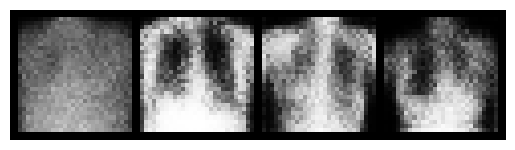

In [16]:
# Load and display generated images
img = plt.imread(f"/kaggle/working/wgan_epoch50.png")
plt.imshow(img)
plt.axis("off")
plt.show()


In [18]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

# Define the log directory
log_dir = "./runs/experiment_1"

# Start TensorBoard
notebook.start("--logdir " + log_dir)


<IPython.core.display.Javascript object>

In [19]:
%load_ext tensorboard
%tensorboard --logdir ./runs


<IPython.core.display.Javascript object>

In [20]:
!zip -r tensorboard_logs.zip ./runs


  adding: runs/ (stored 0%)
  adding: runs/Mar29_07-55-24_ea1b9629ed81/ (stored 0%)
  adding: runs/Mar29_07-55-24_ea1b9629ed81/events.out.tfevents.1743234924.ea1b9629ed81.31.1 (deflated 9%)
  adding: runs/WGAN_training/ (stored 0%)
  adding: runs/WGAN_training/events.out.tfevents.1743233088.ea1b9629ed81.31.0 (deflated 64%)
